In [1]:
import sys
import time
import copy

from scipy.stats import norm
from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
import pickle
import os
from collections import defaultdict

/u/weissmar/venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
dfs = {}
for ex in ['genemania', 'pathway', 'regnet', 'genemania_lr', 'pathway_lr', 'regnet_lr',  'genemania_100', 'pathway_100', 'regnet_100']:
    dfs[ex] = pd.DataFrame(columns=['auc', 'gene_name', 'model', 'num_genes', 'seed', 'train_size'])
    for root, dirs, files in os.walk(os.getcwd() + '/gene_inference/' + ex):
        for f in files:
            if not f.startswith("slurm"):
                block = f.split('-')[-1].split('.')[0]
                graph = root.split('/')[-2]
                try:
                    dfs[ex] = dfs[ex].append(pd.DataFrame(pickle.load(open(os.path.join(root, f), 'rb'))['df']))
                except Exception:
                    import pdb; pdb.set_trace()
                    pass


> <ipython-input-8-9bd3087ec016>(13)<module>()
-> pass
(Pdb) c


In [27]:
agg_df = pd.DataFrame(columns=dfs['genemania'].columns)
for key, df in dfs.items():
    df['exp_id'] = key
    agg_df = pd.concat([agg_df, dfs[key]])


In [71]:
tcgatissue = data.gene_datasets.TCGATissue()
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')


Converting one-hot labels to integers


In [72]:
def create_graph(exp_id, df, std, slice_size, filter_isolates=False, title=''):

    
    if filter_isolates:
        graph = Graph()
        path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"

        #path = "genomics/graph/pancan-tissue-graph.hdf5"
        graph.load_graph(path)
        g = nx.from_numpy_matrix(graph.adj)
        mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
        g = nx.relabel_nodes(g, mapping)
        nodes_to_keep = set(g.nodes()).difference(nx.isolates(g))
        df = df[df['gene_name'].isin(nodes_to_keep)]


    grouped = df.groupby(['gene_name', 'model','train_size','num_genes'])['auc'].agg(['mean','std', 'count'])
    small_neighborhood_mlp_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_mlp_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    small_neighborhood_lr_df = df[df['num_genes'] == 50].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])
    big_neighborhood_lr_df = df[df['num_genes'] == 16300].groupby(['gene_name', 'model','train_size'])['auc'].agg(['mean', 'std'])


    # remove the genes with high variance
    small_neighborhood_mlp_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df['std'] < std]
    big_neighborhood_mlp_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df['std'] < std]


    # reset the index to the gene names (I don't like working with hierarchical indices)
    small_neighborhood_mlp_df.index = small_neighborhood_mlp_df.index.get_level_values(0)
    big_neighborhood_mlp_df.index = big_neighborhood_mlp_df.index.get_level_values(0)


    # Find the genes which are low variance in the small neighborhood and large neighborhood dfs
    intersection = big_neighborhood_mlp_df.index.intersection(small_neighborhood_mlp_df.index)


    big_neighborhood_mlp_intersection_df = big_neighborhood_mlp_df[big_neighborhood_mlp_df.index.isin(intersection)]
    small_neighborhood_mlp_intersection_df = small_neighborhood_mlp_df[small_neighborhood_mlp_df.index.isin(intersection)]
    mlp_low_var_high_mean_df = small_neighborhood_mlp_intersection_df.sub(big_neighborhood_mlp_intersection_df).sort_values('mean', ascending=False)


    index_order = mlp_low_var_high_mean_df.index[0:slice_size]


    line1 = big_neighborhood_mlp_intersection_df[big_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]
    line2 = small_neighborhood_mlp_intersection_df[small_neighborhood_mlp_intersection_df.index.isin(index_order)].loc[index_order.tolist()]

    l1 = line1['mean'] * 100
    l2 = line2['mean'] * 100
    fig, ax = plt.subplots()
    n1, bins1, patches1 = ax.hist(l1, 100, label="MLP - All Genes", density=0, alpha=0.75)
    n2, bins2, patches2 = ax.hist(l2, 100, label="MLP - 50 Neighbors", density=0, alpha=0.75)

    plt.title(title)
    plt.ylabel("Count")
    plt.xlabel("AUC Bucket")

    plt.legend()
    plt.show()


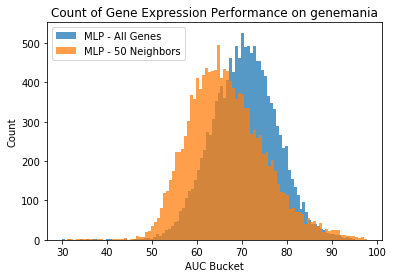

In [62]:
exp_id = 'genemania'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


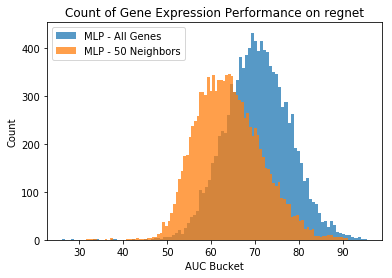

In [64]:
exp_id = 'regnet'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


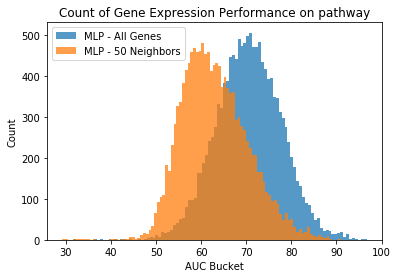

In [65]:
exp_id = 'pathway'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, title="Count of Gene Expression Performance on " + exp_id)


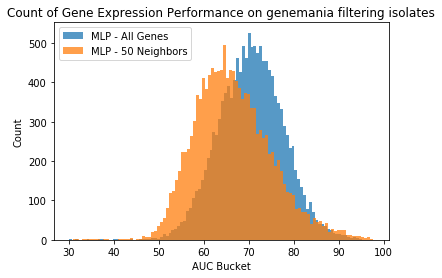

In [100]:
exp_id = 'genemania'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")



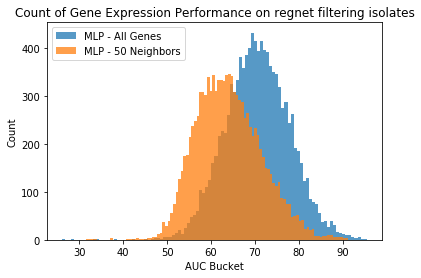

In [78]:
exp_id = 'regnet'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")


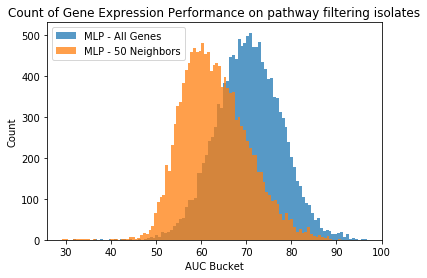

In [77]:
exp_id = 'pathway'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=True, title="Count of Gene Expression Performance on " + exp_id + " filtering isolates")


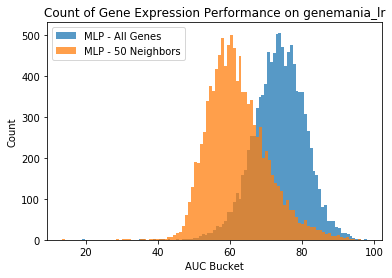

In [81]:
exp_id = 'genemania_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


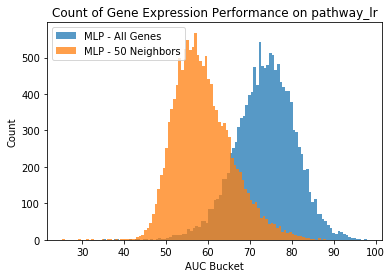

In [82]:
exp_id = 'pathway_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


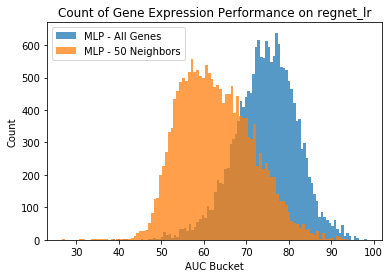

In [84]:
exp_id = 'regnet_lr'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


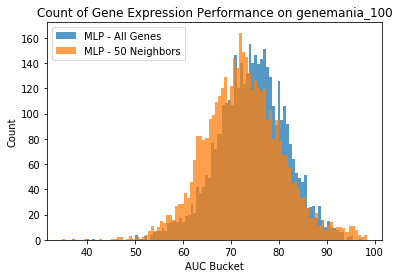

In [113]:
exp_id = 'genemania_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


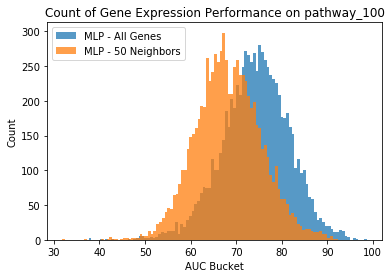

In [114]:
exp_id = 'pathway_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)


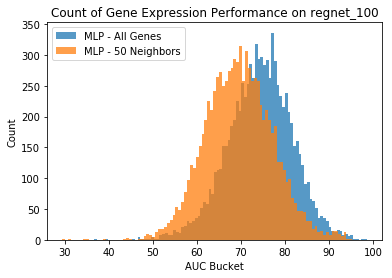

In [115]:
exp_id = 'regnet_100'
df = agg_df[agg_df['exp_id']==exp_id].dropna()
df = df[df['model'] == 'MLP']
std = 1.0
slice_size = 100000
create_graph(exp_id, df, std, slice_size, filter_isolates=False, title="Count of Gene Expression Performance on " + exp_id)
